In [1]:
from functools import reduce
import operator

import numpy as np

from cospar import reader, F
from everest.window import Canvas, DataChannel
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


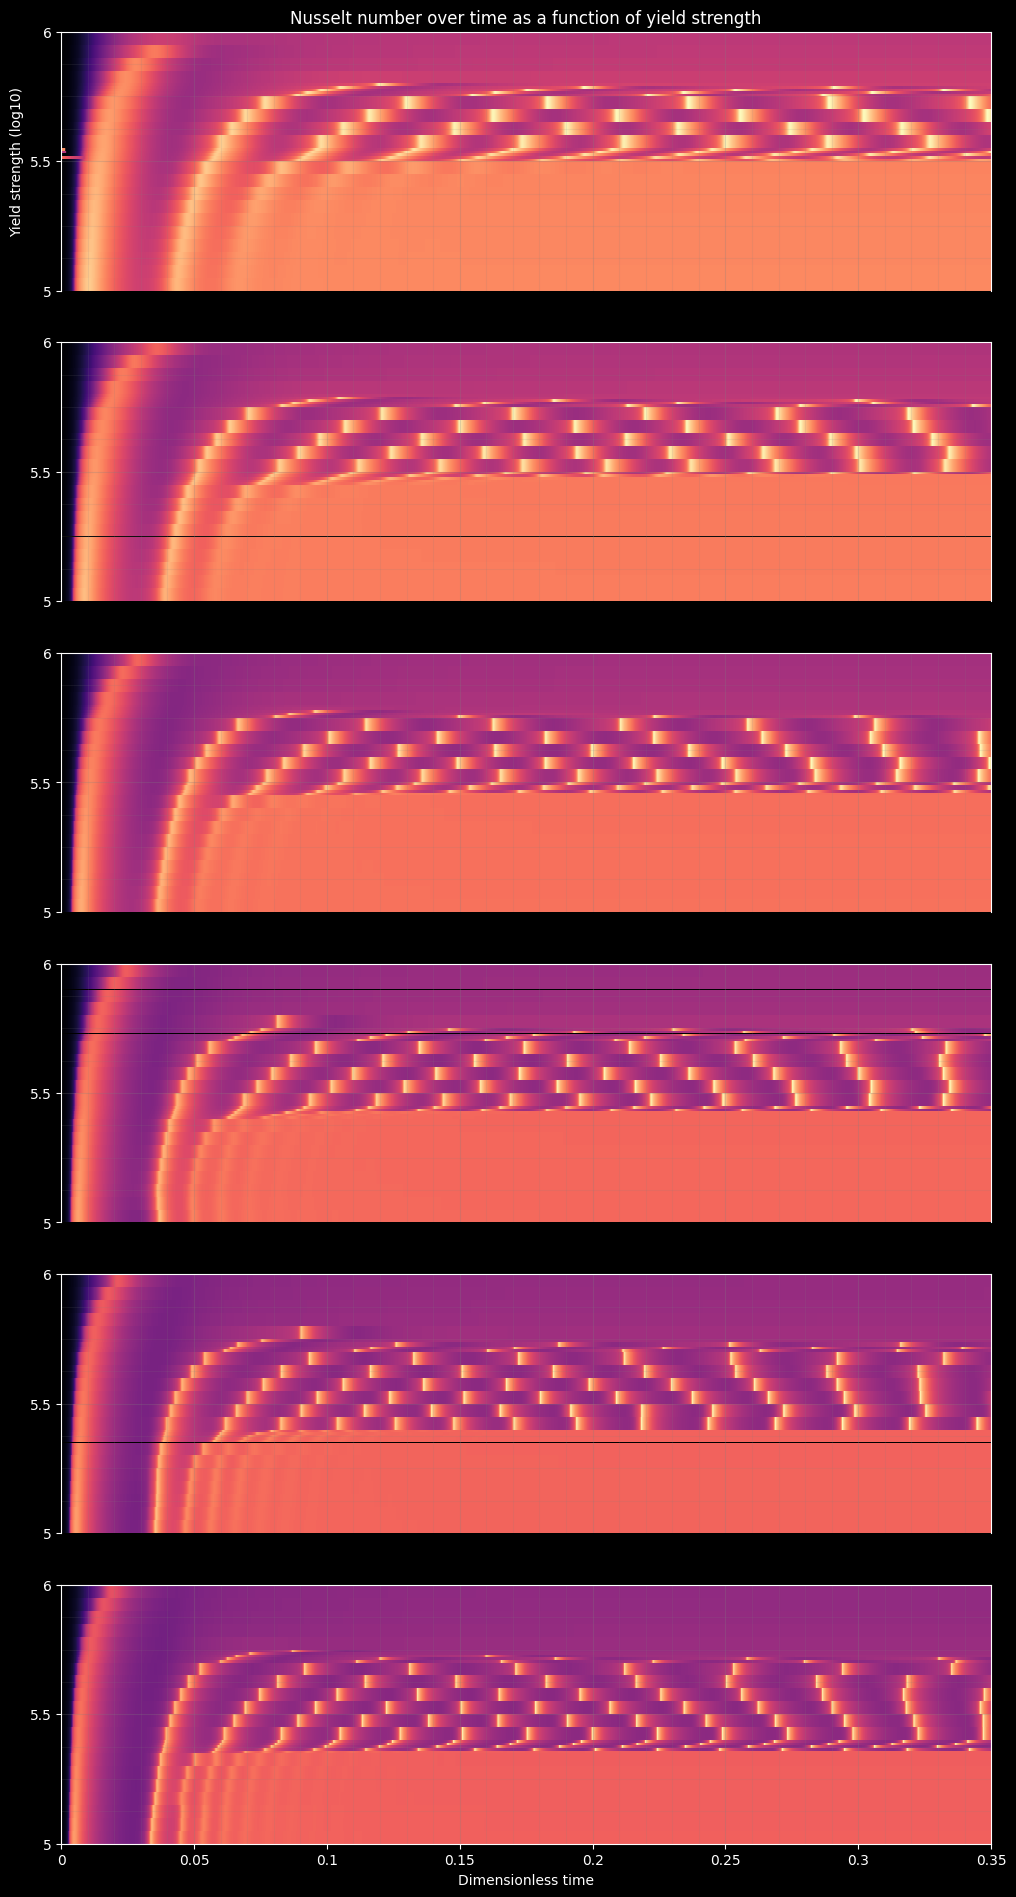

In [21]:
fs = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

canvas = Canvas(size = (12, 24), shape = (len(fs), 1), colour = 'white', fill = 'black')

for i, f in enumerate(fs):

    conds = (
        F('inputs/aspect') == 1,
        F('inputs/f') == f,
        F('inputs/tauRef') <= 1e6,
        F('inputs/tauRef') >= 1e5,
        F('inputs/temperatureField') == '_built_peaskauslu-thoesfthuec',
        )
    cut = reader[reduce(operator.__and__, conds)]
    datas = reader[cut : ('tauRef', 't', 'Nu')]
    datas = {k : v for k, v in datas.items() if len(v[1])}

    alltau, allt, allNu = [], [], []
    alls = []
    tauVals = np.log10(np.array(sorted(set(tau for tau, *_ in datas.values()))))
    tauDiff = np.diff(tauVals)
    sDict = dict(zip(tauVals, tauDiff))
    sDict[tauVals[-1]] = tauDiff[-1]
    ssum = sum(sDict.values())
    for tauRef, t, Nu in datas.values():
        tauRef = np.log10(tauRef)
        alltau.extend(np.full(t.shape, tauRef))
        allt.extend(t)
        allNu.extend(Nu)
        alls.extend(np.full(t.shape, sDict[tauRef] / ssum))
    alltau, allt, allNu = np.array(alltau), np.array(allt), np.array(allNu)
    alls = np.array(alls)

    ax = canvas.make_ax(place = (i, 0))

    ax.scatter(
        DataChannel(allt, lims = (0, 0.35), label = 'Dimensionless time'),
        DataChannel(alltau, lims = (5, 6), label = 'Yield strength (log10)'),
        c = np.log10(allNu),
        cmap = 'magma',
        s = 1.1 * (alls * ax.inches[1] * 72) ** 2,
        alpha = 1.,
        marker = 2,
        )

    if i == 0:
        ax.props.title.text = 'Nusselt number over time as a function of yield strength'
    if i != 0:
        ax.props.edges.y.label.text = ''
    if i != (len(fs) - 1):
        ax.props.edges.x.primary.alpha = 0.

canvas.show()